In [3]:
# check versions and devices
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
print("python version: ", sys.version)
# print("tf version: ", tf.__version__)
# print("devices: ", tf.config.list_physical_devices())

python version:  3.9.13 (main, Oct 13 2022, 16:12:30) 
[Clang 12.0.0 ]


In [7]:
# create train and validation datasets
batch_size = 128
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./data/images/",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./data/images/",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

train_ds.class_names

Found 16041 files belonging to 2 classes.
Using 12833 files for training.
Found 16041 files belonging to 2 classes.
Using 3208 files for validation.


['car', 'not_car']

In [8]:
# configure performance
autotune = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=autotune)
val_ds = val_ds.cache().prefetch(buffer_size=autotune)

In [ ]:
# transfer lerning from tensorflow hub
import tensorflow_hub as hub
resnet_50 = "https://tfhub.dev/tensorflow/resnet_50/classification/1"

In [ ]:
# model
model = tf.keras.Sequential([
    # input layer
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
    # rescaling
    tf.keras.layers.Rescaling(1./255),
    # transfer learning
    # hub.KerasLayer(resnet_50, trainable=False, dtype=tf.float32, include_top=False),
    # global average pooling
    # tf.keras.layers.GlobalAveragePooling2D(),
    # dropout
    # tf.keras.layers.Dropout(0.2),
    # hidden layers
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(16, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    # output layer
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.summary()



In [ ]:
# compile model
model.compile(
    optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [9]:
# train
import tensorflow as tf
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3


2022-11-18 11:33:05.053391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


101/101 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.9934

2022-11-18 11:33:47.586225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


101/101 [==============================] - 49s 463ms/step - loss: 0.0207 - accuracy: 0.9934 - val_loss: 0.2166 - val_accuracy: 0.9489
Epoch 2/3
101/101 [==============================] - 42s 414ms/step - loss: 0.0058 - accuracy: 0.9988 - val_loss: 0.2421 - val_accuracy: 0.9501
Epoch 3/3
101/101 [==============================] - 42s 415ms/step - loss: 0.0031 - accuracy: 0.9997 - val_loss: 0.2577 - val_accuracy: 0.9501


In [10]:
# save model
import pandas as pd

model.save('model.h5')
hist_df = pd.DataFrame(history.history)
with open("hist.json", "w") as f:
    hist_df.to_json(f)


In [12]:
# load
from tensorflow.keras.models import load_model
import pandas as pd
from tensorflow_hub import KerasLayer
import pandas as pd

model = load_model('model.h5')
model_hist = pd.read_json("hist.json")

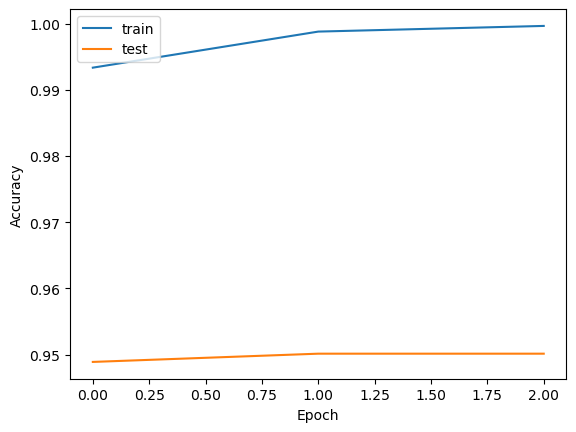

In [13]:
# plot accuracy and val_accuracy
import matplotlib.pyplot as plt
plt.plot(model_hist['accuracy'], label='train')
plt.plot(model_hist['val_accuracy'], label = 'test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

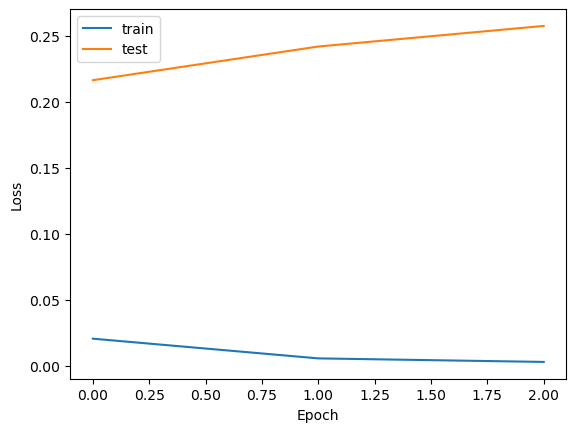

In [14]:
# plot loss and val_loss
plt.plot(model_hist['loss'], label='train')
plt.plot(model_hist['val_loss'], label = 'test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()